# Predicting flight delay

Predicting flight delays at take-off. 

The entire notebook is divided into 4 Major sections. 
1. Understanding and Cleaning Data
2. Re-sampling of the data
3. Exploratory Data Analysis
4. Building various model to detect the delays

In [85]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

#### Loading the data 
In this dataset, we have 3 input files and 1 kernel output file. You can see the details in the workspace to the right

Input files:

- **flights.csv**: Contains entire dataset of the flights data for 2015. Contains around 58 million data records
- **aiports.csv**: Contains the lookup table for Airports
- **airlines.csv**: Contains the lookup table for Airlines

Kernel output file:
- **flights_date**: Contains pre-processed output file that can be readily used for data analysis. It contains the data after the clearning of date format and added lookup data to flights data. This avoids to perform costly operations again and again. However, in this kernel the cells which cleans up the data has been commented, but kept for future purposes. 

In [2]:
airports = pd.read_csv("airports.csv")

Finding the datatype, number of null values and their perecentages in each column:

In [3]:
df = pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


In [4]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


___
## 1. Data Acquaintance and Cleaning
___
### 1.1 Dates and times

In the initial dataframe, dates are coded according to 4 variables: **YEAR, MONTH, DAY**, and **DAY_OF_WEEK**. In fact, python offers the **_datetime_** format which is really convenient to work with dates and times and I thus convert the dates in this format:


In [5]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

Changing "Scheduled Departure" variable from float to datetime format

In [6]:
# Function that convert the 'HHMM' string to datetime.time

def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

and I call them to modify the dataframe variables:

In [9]:
#df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
#df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
#df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
#df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
#df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
        #     'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

**NOTE**
The above cell is very Costly Operation. For this reason, I have saved it and renamed as an other csv file and I am using it further.


In [ ]:
# df.to_csv('flights_date.csv')

#### End of Data Processing

<a id='load_file'> </a>
#### LOAD flight_date.csv
As the date conversion and other pre-processing steps are expensive for 5.8 million records, I am loading already pre-processed file

In [10]:
df = pd.read_csv('flights_date.csv', low_memory=False)

Let us save original flights data in a dataframe for later analysis

In [ ]:
# flights_original = df

This is how the data looks like. 

In [11]:
df.head()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,04:30:00,04:08:00,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,07:50:00,07:41:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,08:06:00,08:11:00,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,08:05:00,07:56:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,03:20:00,02:59:00,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01


### 1.2 Removing Cancelled Flights info
As we are analysing the delays, not considering the flights those have been cancelled.

In [12]:
total_count = df['AIRLINE'].count()
cancelled_count = df[df['CANCELLED'] == 1]['AIRLINE'].count()

print('Total flights', total_count, 'and Cancelled flights',cancelled_count, '. So % of cancelled flights: ', round(cancelled_count/total_count*100,2) ,'%')

Total flights 5819079 and Cancelled flights 89884 . So % of cancelled flights:  1.54 %


Let us remove those cancelled flights, as they will not add any value in performing prediction of flight delays

In [13]:
df = df[df['CANCELLED'] == 0]

### 1.3 Filling factor

Finally, I clean the dataframe throwing the variables I won't use and re-organize the columns to ease its reading:

In [14]:
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME',  'DAY_OF_WEEK', 'ELAPSED_TIME', 'MONTH']]

df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,DAY_OF_WEEK,ELAPSED_TIME,MONTH
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,4,194.0,1
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,4,279.0,1
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,4,293.0,1
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,4,281.0,1
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,4,215.0,1


At this stage, I examine how complete the dataset is:

In [15]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,15187,99.734919
1,ELAPSED_TIME,15187,99.734919
2,ARRIVAL_TIME,2629,99.954112
3,SCHEDULED_TIME,1,99.999983
4,AIRLINE,0,100.000000
5,ORIGIN_AIRPORT,0,100.000000
6,DESTINATION_AIRPORT,0,100.000000
7,SCHEDULED_DEPARTURE,0,100.000000
8,DEPARTURE_TIME,0,100.000000
9,DEPARTURE_DELAY,0,100.000000


In [16]:
df.shape

(5729195, 13)

We see that the variables filling factor is quite good (> 99%). Not doing any imputation, and simply removing the missing values

In [17]:
df.dropna(inplace = True)
df.shape

(5714008, 13)

### 1.4 Perform resampling for analysis

Instead of 5.7 million records which is a huge dataset, resampling is done.

Using few months data - and see if the feature affects the delay largely or not.

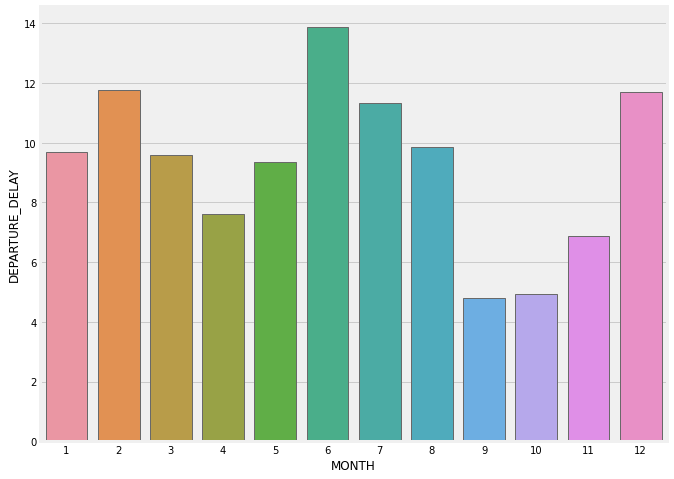

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(data=df, x='MONTH',y='DEPARTURE_DELAY', ax=ax, ci=None)

One month from each Quarter for analysis purpose. Let us consider follwoing months - Feb, Jun, Aug and Dec. This will help in saving time during EDA and also modelling. 

In [19]:
df = df[df['MONTH'].apply(lambda x:x in [2,6,8,12])  ]
df.shape

(1874183, 13)

___
## 2. Exploratory Data Analysis

### 2.1 Comparing airlines
For further use, I put the content of this this dataframe in a dictionary:

In [20]:
airlines_names = pd.read_csv('airlines.csv')
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

___
### 2.2 Basic statistical description of airlines

As a first step, I consider all the flights from all carriers. Here, the aim is to classify the airlines with respect to their punctuality and for that purpose, I compute a few basic statisticial parameters:

In [21]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-22.0,644.0,20409.0,12.090646
HA,-27.0,1433.0,25541.0,1.450765
F9,-34.0,852.0,29626.0,16.701580
NK,-35.0,723.0,37838.0,22.313600
AS,-82.0,963.0,57354.0,2.677616
US,-24.0,759.0,62398.0,8.607616
B6,-26.0,1006.0,87332.0,15.689117
MQ,-35.0,1278.0,90190.0,11.738607
UA,-36.0,1194.0,167412.0,17.925220


Now, in order to understand the data, let us see some graphics:

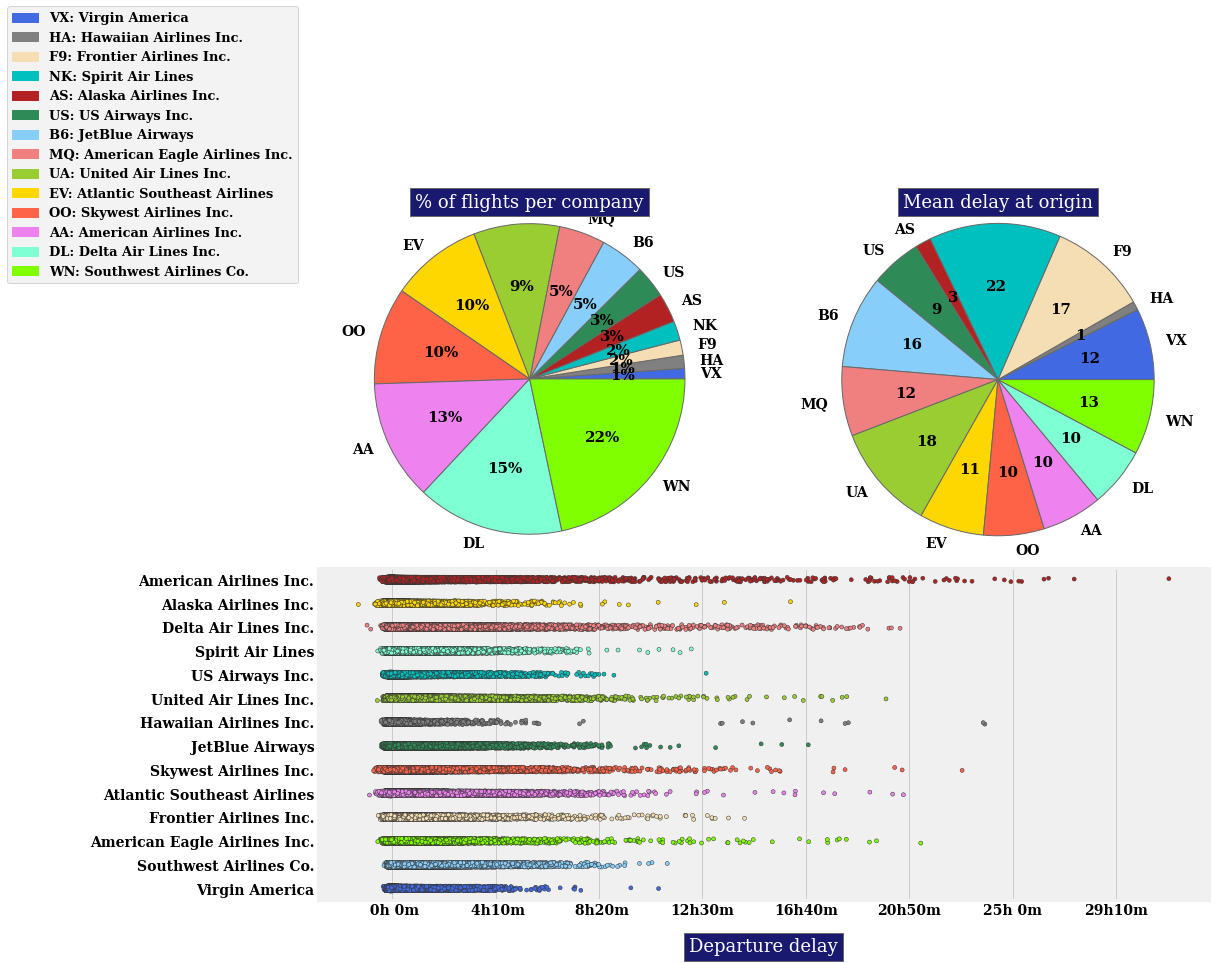

In [22]:
font = {'family' : 'serif', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart n0. 1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

First pie chart that gives the percentage of flights per airline, we see that there is some disparity between the carriers. For exemple, *Southwest Airlines* accounts for $\sim$20% of the flights which is similar to the number of flights chartered by the 7 tiniest airlines. 

Second pie chart, we see that here, on the contrary, the differences among airlines are less pronounced. Excluding *Hawaiian Airlines* and *Alaska Airlines* that report extremely low mean delays, we obtain that a value of **$\sim$11$\pm$7 minutes** would correctly represent all mean delays. 

Finally, the figure at the bottom makes a census of all the delays that were measured in January 2015. This representation gives a feeling on the dispersion of data and put in perspective the relative homogeneity that appeared in the second pie chart.

---
### 2.3 Delays Categorization





The two numbers match up, which infers that only the flights with arrival delay >= 15 minutes having a detailed delay breakdown (e.g. air system, airline, weather).

So, let us try to categorize the delays as:
- Anything <15 min as **On time**
- 15 min to 1 hour as **Short Delay**
- Beyond 1 hour as **Long Delay** 

The different type of delays are visible in the next figure:

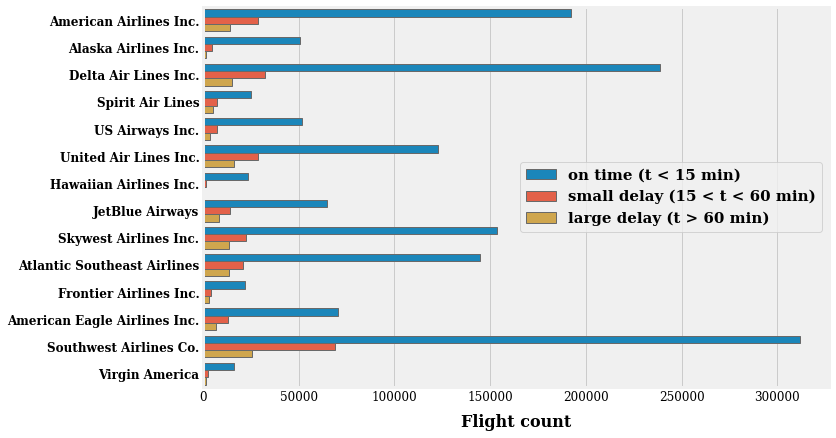

In [23]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 15],2)[x > 60]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 15 min)')
L.get_texts()[1].set_text('small delay (15 < t < 60 min)')
L.get_texts()[2].set_text('large delay (t > 60 min)')
plt.show()

We see that independently of the airline, delays greater than 60 minutes only account for a few percents. 

However, the proportion of delays in these three groups depends on the airline: as an exemple
1. In the case of *SkyWest Airlines*, the flights with delay greater than 60 minutes are more than $\sim$50% with respect to delays in the range 15 < t < 60 min. 
2. For *SoutWest Airlines*  since delays greater than 60 minutes are around $\sim$35% of that of in the range 15 < t < 60 min.


In [24]:
total = df['AIRLINE'].count()
ontime = df[df['DELAY_LEVEL'] == 0]['AIRLINE'].count()
pct_ontime = ontime/total*100
print('Ontime%: ',pct_ontime)

small_delay = df[df['DELAY_LEVEL'] == 1]['AIRLINE'].count()
pct_small_delay = small_delay/total*100
print('Small delay%: ', pct_small_delay)


large = df[df['DELAY_LEVEL'] == 2]['AIRLINE'].count()
pct_large = large/total*100
print('Large delay%: ', pct_large)

Ontime%:  79.41028170674902
Small delay%:  13.735638408842679
Large delay%:  6.8540798844083


---
### 2.4 Delays distribution: establishing the ranking of airlines

It was shown in the previous section that mean delays behave homogeneously among airlines (apart from two extrem cases) and is around 11$\pm$7 minutes. Then, we saw that this low value is a consequence of the large proportion of flights that take off on time. However, occasionally, large delays can be registred. In this section, I examine more in details the distribution of delays for every airlines:

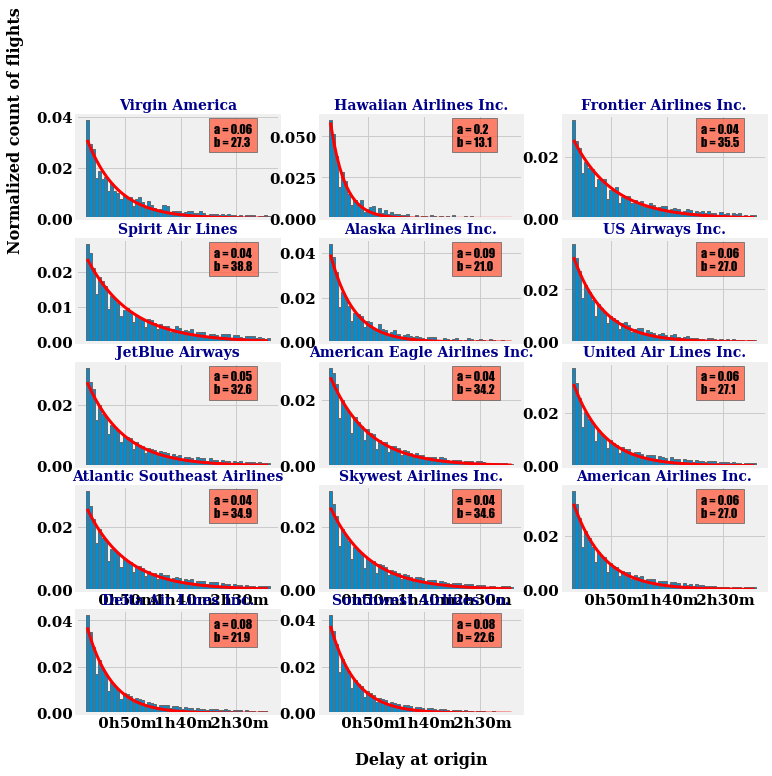

In [25]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), density=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

This figure shows the normalised distribution of delays that I modelised with an exponential distribution $ f(x) = a \, \mathrm{exp} (-x/b)$. The $a$ and $b$ parameters obtained to describe each airline are given in the upper right corner of each panel. Note that the normalisation of the distribution implies that $\int f(x) \, dx \sim 1$. Here, we do not have a strict equality since the normalisation applies the histograms but not to the model function. However, this relation entails that the $a$ and $b$ coefficients will be correlated with $a \propto 1/b$ and hence, only one of these two values is necessary to describe the distributions. Finally, according to the value of either $a$ or $b$, it is possible to establish a ranking of the companies: the low values of $a$ will correspond to airlines with a large proportion of important delays and, on the contrary, airlines that shine from their punctuality will admit hight $a$ values:

Based on above explanation, we can decide that Hawaiin Airlines is most punctual followed by Alaska, Southwest and Delta Airlines. But, we can recall here that Hawaiin and Alaska Airliens have very less volume of flights.

___
### 2.5 Delays: take-off or landing ?
In the previous section, all the discussion was done on departure delays. However, these delays differ somewhat from the delays recorded at arrival:

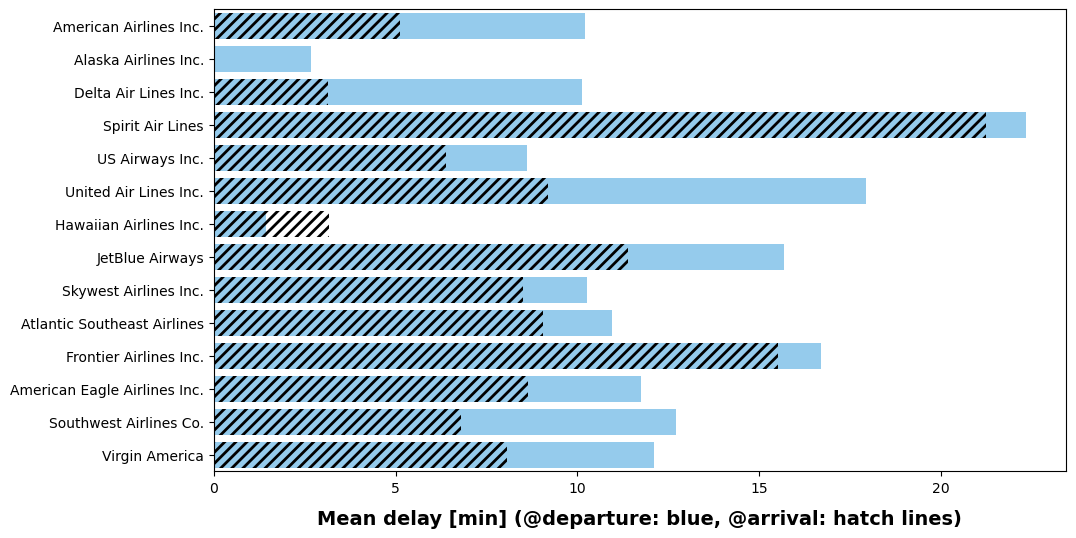

In [26]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

On this figure, we can see that delays at arrival are generally lower than at departure. This indicates that airlines adjust their flight speed in order to reduce the delays at arrival. In what follows, I will just consider the delays at departure but one has to keep in mind that this can differ from arrival delays.

---
### 2.6 Relationship with delays and weekday
I am hypothesising that delay can be associated with the day of the week. 

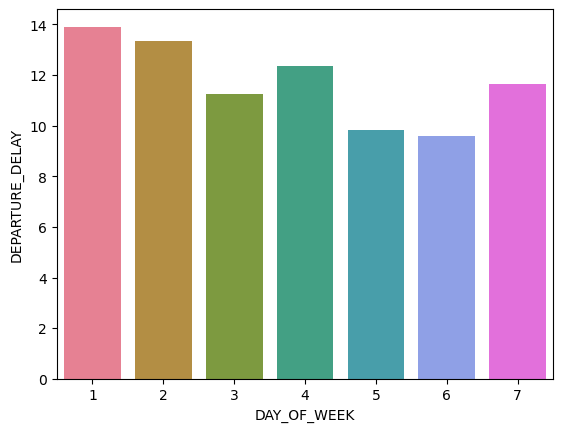

In [27]:
ax = sns.barplot(x="DAY_OF_WEEK", y="DEPARTURE_DELAY", data=df, palette="husl", ci=None)

We can see that avg  delays are more on Mondays and Tuesday. But variation is not too much. We will not consider this as important feature that will impact delays

___
### 2.7. Relation between the origin airport and delays

I will now try to define if there is a correlation between the delays registered and the airport of origin. I recall that in the dataset, the number of airports considered is: 

In [28]:
print("No. of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

No. of airports: 322


In [29]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

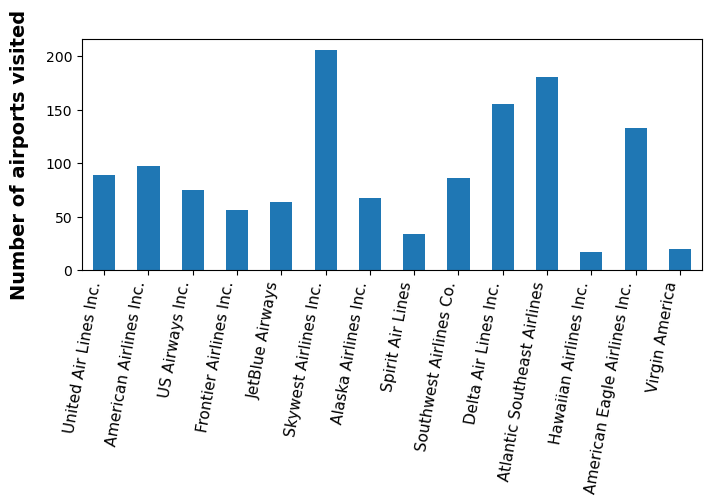

In [30]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

___
#### 2.7.1 How the origin airport impact delays

In this section, I will have a look at the variations of the delays with respect to the origin airport and for every airline. The first step thus consists in determining the mean delays per airport:

In [31]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

Since the number of airports is quite large, a graph showing all the information at once would be a bit messy, since it would represent around 4400 values (i.e. 312 airports $\times$ 14 airlines). Hence, I just represent a subset of the data:

In [32]:
identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()

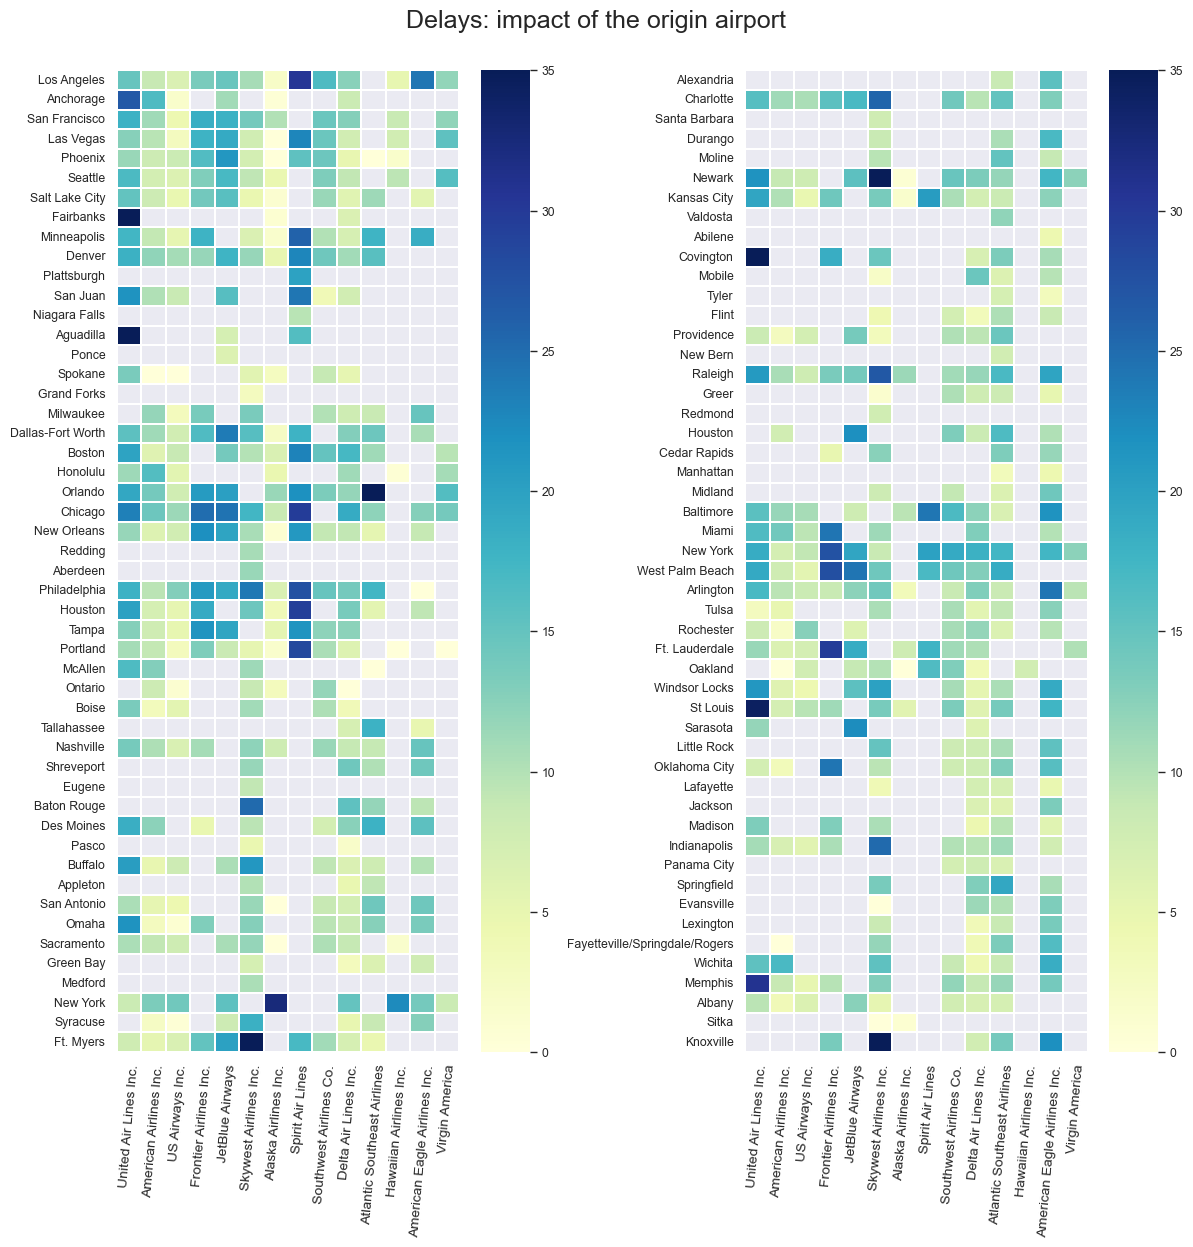

In [33]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(12,12))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

This figure allows to draw some conclusions. First, by looking at the data associated with the different airlines, we find the behavior we previously observed: for example, if we consider the right panel, it will be seen that the column associated with  *American Eagle Airlines* mostly reports large delays, while the column associated with *Delta Airlines* is mainly associated  with delays of less than 5 minutes. If we now look at the airports of origin, we will see that some airports favor late departures: see e.g. Denver, Chicago or New York. Conversely, other airports will mainly know on time departures such as Portland or Oakland.

Finally, we can deduce from these observations that there is a high variability in average delays, both between the different airports but also between the different airlines. This is important because it implies that in order to accurately model the delays, it will be necessary to adopt a model that is ** specific to the company and the home airport **. 

---
## 3. Feature Engineering
With all the data analysis done in Section 2, we can deduce that the DEPARTURE_DELAY target variable has following feature variables
1. Airline
2. Airport
3. Departure time

Out of these above features, Airline and Airport are categorical variables. In this section, we convert these categorical valriables in numerical variables using encoding techiques. We can use Label encoding or OneHot Encoding. 

In [68]:
df['dep_hour'] = pd.to_datetime(df['SCHEDULED_DEPARTURE']).apply(lambda x:x.time().hour)

In [69]:
fct = lambda x:x.hour*3600+x.minute*60+x.second
df['heure_depart'] = pd.to_datetime(df['SCHEDULED_DEPARTURE']).apply(lambda x:x.time())
df['heure_depart'] = df['heure_depart'].apply(fct)
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,DAY_OF_WEEK,ELAPSED_TIME,MONTH,DELAY_LEVEL,heure_depart,dep_hour
469968,AA,LAX,DFW,2015-02-01 00:05:00,00:02:00,-3.0,04:54:00,04:52:00,-2.0,169.0,7,170.0,2,0,300,0
469969,AS,ANC,SEA,2015-02-01 00:05:00,00:34:00,29.0,04:29:00,05:01:00,32.0,204.0,7,207.0,2,1,300,0
469970,AA,LAX,MIA,2015-02-01 00:20:00,00:10:00,-10.0,08:04:00,08:49:00,45.0,284.0,7,339.0,2,0,1200,0
469971,DL,SFO,MSP,2015-02-01 00:20:00,00:12:00,-8.0,06:00:00,05:48:00,-12.0,220.0,7,216.0,2,0,1200,0
469972,NK,LAS,MSP,2015-02-01 00:25:00,00:16:00,-9.0,05:26:00,05:15:00,-11.0,181.0,7,179.0,2,0,1500,0


We encode Airline and Airport using Label Encodign 

In [70]:
df = df[['AIRLINE','ORIGIN_AIRPORT', 'heure_depart', 'dep_hour', 'DEPARTURE_DELAY' ]]
le = LabelEncoder()
df['AIRLINE'] = le.fit_transform(df['AIRLINE'])
df['ORIGIN_AIRPORT'] = le.fit_transform(df['ORIGIN_AIRPORT'])
df.head()


,AIRLINE,ORIGIN_AIRPORT,heure_depart,dep_hour,DEPARTURE_DELAY
469968,0,176,300,0,-3.0
469969,1,17,300,0,29.0
469970,0,176,1200,0,-10.0
469971,3,278,1200,0,-8.0
469972,8,174,1500,0,-9.0


We are now ready for building our models

---
## 4.0 Model Building and Testing

Due to the fact that any delay which are more than 60 min is considered as **Large Delay**, let us remove that from our original data set. We can consider them as outliers.

In [71]:
df2 = df
df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
df2 = df2.dropna(how = 'any')
df2.head()

,AIRLINE,ORIGIN_AIRPORT,heure_depart,dep_hour,DEPARTURE_DELAY
469968,0,176,300,0,-3.0
469969,1,17,300,0,29.0
469970,0,176,1200,0,-10.0
469971,3,278,1200,0,-8.0
469972,8,174,1500,0,-9.0


We now split the data into X and Y. X which are the features of the model are - *AIRLINE*, *ORIGIN_AIRPORT* AND departure hour (*dep_hour*). The mean of DEPARTURE_DELAY  is our Y. 

In [72]:
features = ['AIRLINE', 'ORIGIN_AIRPORT', 'dep_hour']
df2 = df2.groupby(features ).mean()

df2 = df2.drop([ 'heure_depart'], axis=1)
df2 = df2.dropna(how='any')
df2.head()

DEPARTURE_DELAY
AIRLINE ORIGIN_AIRPORT dep_hour                 
0       2              0                0.206897
                       6               -4.762712
                       7               -2.960000
                       8               -0.091954
                       9               -0.434783

In [73]:
df2 = df2.reset_index()
y = df2['DEPARTURE_DELAY']
# X = df.drop(['DEPARTURE_DELAY'], axis=1)
X = df2[features]

Next we split the data into train and test data. 70% train and 30% test data

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 4.1 Baseline Model

Let us now build a Naive Linear Model

In [75]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

We use MSE and R2 as Metrics

In [76]:
results = model.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  29.532693610459823   R2 Score:  0.15612181173978978


This is our baseline model. Let us try other models to beat this metric

---
### 4.2 Polynomial Model

We will try to improve the model by using polynomial model. In the section below, we create a grid search to get best parameter for Polynomial model

In [77]:
for i in range(1,10):
    poly = PolynomialFeatures(degree = i)
    regr = linear_model.LinearRegression()
    X_ = poly.fit_transform(X_train)
    regr.fit(X_, y_train)
    X_ = poly.fit_transform(X_test)
    results = regr.predict(X_)
    score1 = metrics.mean_squared_error(y_test,results )
    score2 = metrics.r2_score(y_test,results )
    print('Model with Polynominal Degree', i, 'MSE: ',score1, '  R2 Score: ', score2)

Model with Polynominal Degree 1 MSE:  29.532693610459823   R2 Score:  0.15612181173978978
Model with Polynominal Degree 2 MSE:  29.248959927372525   R2 Score:  0.16422932369214704
Model with Polynominal Degree 3 MSE:  28.757918487081287   R2 Score:  0.17826052472173703
Model with Polynominal Degree 4 MSE:  28.196360628471908   R2 Score:  0.19430668815597008
Model with Polynominal Degree 5 MSE:  28.16362908766537   R2 Score:  0.19524197139559318
Model with Polynominal Degree 6 MSE:  28.181826103855776   R2 Score:  0.19472200307651433
Model with Polynominal Degree 7 MSE:  29.712579262083857   R2 Score:  0.15098169212223034
Model with Polynominal Degree 8 MSE:  29.872734108471967   R2 Score:  0.1464053678832784
Model with Polynominal Degree 9 MSE:  35.856549955295044   R2 Score:  -0.024578415116838226


We can see that polynomial order 4 gives best MSE result.

---
#### 4.2.1 Cross Validation for Polynomial Model

Now let use Cross Validation for Polynomial Model

In [78]:
nb_folds = 10
for i in range(1,10):
    poly = PolynomialFeatures(degree = i)
    regr = linear_model.LinearRegression()
    X_ = poly.fit_transform(X )
    results = cross_val_predict(regr, X_, y, cv = nb_folds)
    
    score1 = np.mean(cross_val_score(regr, X_, y,cv = nb_folds, scoring = 'neg_mean_squared_error'))   
    score2 = np.mean(cross_val_score(regr, X_, y,cv = nb_folds, scoring = 'r2'))
    print('Model with Polynominal Degree', i, 'MSE: ',score1, '  R2 Score: ', score2)

Model with Polynominal Degree 1 MSE:  -32.40219599472951   R2 Score:  0.08626266134264293
Model with Polynominal Degree 2 MSE:  -32.73976104388866   R2 Score:  0.07620437750019692
Model with Polynominal Degree 3 MSE:  -32.689410496495405   R2 Score:  0.07708135841984415
Model with Polynominal Degree 4 MSE:  -34.11858244052477   R2 Score:  0.020066922384790697
Model with Polynominal Degree 5 MSE:  -38.34493395411607   R2 Score:  -0.14170437556895243
Model with Polynominal Degree 6 MSE:  -54.67087592170011   R2 Score:  -0.7687359323766876
Model with Polynominal Degree 7 MSE:  -75.90232409175243   R2 Score:  -1.5978357563750887
Model with Polynominal Degree 8 MSE:  -103.74627222940694   R2 Score:  -2.4593391184277427
Model with Polynominal Degree 9 MSE:  -93.64520290346233   R2 Score:  -2.0949688947460983


---
### 4.3 Random Forest Regression
As we have seen, the data is not linear, so let us try some tree based algorithm. Let us try Random Forest Algorithm

In [79]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(n_estimators=50, max_depth=1000 )
model2.fit(X_train, y_train)

RandomForestRegressor(max_depth=1000, n_estimators=50)

Let us try to predict and evaluate the values 

In [80]:
results2 = model2.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results2 )
score2 = metrics.r2_score(y_test,results2 )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  30.14457857138051   R2 Score:  0.1386375829370864


We can observe that this has not improves much compared to baseline model.

---
### 4.4 Ridge Regression
Let us try to use Ridge technique, which helps to improve the model by regularization.

In [81]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.0001,normalize=True)
poly = PolynomialFeatures(degree = 3)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, y_train)

Ridge(alpha=0.0001, normalize=True)

In [82]:
X_ = poly.fit_transform(X_test)
results = ridgereg.predict(X_)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  28.751280848857462   R2 Score:  0.17845019106888882


Now, if we calculate the score associated to the predictions made with a regularization technique

And we can see that we obtain a reasonable score. Hence, with the current procedure, to determine the best model, we have two free parameters to adjust: the polynomial order and the $\alpha$ coefficient of the * 'Ridge Regression' *:

In [83]:
score_min = 10000
for pol_order in range(1, 5):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10000, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 29.533
n=1 alpha=2 , MSE = 29.533
n=1 alpha=4 , MSE = 29.533
n=1 alpha=6 , MSE = 29.533
n=1 alpha=8 , MSE = 29.533
n=1 alpha=10 , MSE = 29.533
n=1 alpha=12 , MSE = 29.533
n=1 alpha=14 , MSE = 29.533
n=1 alpha=16 , MSE = 29.533
n=1 alpha=18 , MSE = 29.533
n=2 alpha=0 , MSE = 29.249
n=2 alpha=2 , MSE = 29.249
n=2 alpha=4 , MSE = 29.249
n=2 alpha=6 , MSE = 29.249
n=2 alpha=8 , MSE = 29.25
n=2 alpha=10 , MSE = 29.25
n=2 alpha=12 , MSE = 29.25
n=2 alpha=14 , MSE = 29.25
n=2 alpha=16 , MSE = 29.25
n=2 alpha=18 , MSE = 29.251
n=3 alpha=0 , MSE = 28.758
n=3 alpha=2 , MSE = 28.757
n=3 alpha=4 , MSE = 28.783
n=3 alpha=6 , MSE = 28.811
n=3 alpha=8 , MSE = 28.837
n=3 alpha=10 , MSE = 28.861
n=3 alpha=12 , MSE = 28.881
n=3 alpha=14 , MSE = 28.899
n=3 alpha=16 , MSE = 28.915
n=3 alpha=18 , MSE = 28.929
n=4 alpha=0 , MSE = 28.196
n=4 alpha=2 , MSE = 28.554
n=4 alpha=4 , MSE = 28.632
n=4 alpha=6 , MSE = 28.669
n=4 alpha=8 , MSE = 28.692
n=4 alpha=10 , MSE = 28.709
n=4 alpha=12 , MS

This grid search allows to find the best set of $\alpha$ and $n$ parameters. Let us note, however, that for this model, the estimates obtained with a linear regression or a polynomial of order 3 are quite close. Also we can see the best results are obtained for $\alpha$ value to be *0*. It means that model is ordinary least square regression model

---
### 4.5 LightGBM algorithm

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

In [89]:
pip install lightgbm

  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [90]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
# params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 9011, number of used features: 3
[LightGBM] [Info] Start training from score 1.884559
MSE:  26.430206575170782   R2 Score:  0.244773431973754


We can tweak many of the LightGBM hyperparameters for better results, I observed that ```boosting_type``` and ```learning_rate``` affected the most for the results. 

## 5.0 Model Evaluation

So far LightGBM regression with ```boosting_type = gbdt``` with ```learning_rate = 0.08``` has fit the model the best way with the above MSE and R2 score.

To get an idea of the meaning of such a value for the MSE, we can assume a constant error on each point of the dataset. In which case, at each point $ i $, we have:

\begin{eqnarray}
y_i - f(x_i) = cste = \sqrt{MSE}
\end{eqnarray}

thus giving the difference in minutes between the predicted delay and the actual delay. In this case, the difference between the model and the observations is thus typically:

In [91]:
'Estimation Error = {:.2f} min'.format(np.sqrt(score1))

'Estimation Error = 5.14 min'

## 6.0 Conclusion

By keeping the original problem which is to predict the flight departure delays, we have considered multiple features and selected top 3 features which has major impacts on delays. (Features)

- Airport
- Airline
- Time of departure (Hour)

We then constructed base model and then improvised multiple other models. At the end we found the best model based on best Metric output which is **LightGBM**. We can use that model to predict any flight delays provided Airport, Airline and time of departure. We can estimate the delay with approximation of *5~6 min*.




## Improvements
Definitely, we can improve the solution for this problem. Following are some of the improvement ideas:

* First of all, we have eliminated Cancelled flights, however in the improved model we can also predict the possibiltiy of cancellation
* We have removed all the flights which have delays more than 1 hour. We can build a 2 step soltution, first one, which classifies if the flight gets **cancelled**, **short_delay**, **large_delay**  or  **ontime**. Then in the second step, it can predict the actual delay using regression
* We can perform an ensemble of LightGBM and Ridge Regression models for better generalization 
* We can also explore more hyperparameter tuning for LightGBM to improve the model
* In this solution, we took only 4 months of data due to low power kernels, we can get more powerful kernel and consider all 12 months data
* We can also model the solution using Neural Network with multiple layers